# Keras MNIST ordinary 'fit' training

Using TensorFlow backend.


Python: 3.6.1, TensorFlow:1.2.0, Keras:2.0.5
(60000, 784) TRAIN samples
(10000, 784) TEST samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               640800    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                8010      
Total params: 1,276,810
Trainable params: 1,276,810
Non-trainable params: 0
_________________________________________________________________
Running process: [timeout 300 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv,nounits -lms 100 -f GPU-info.csv]


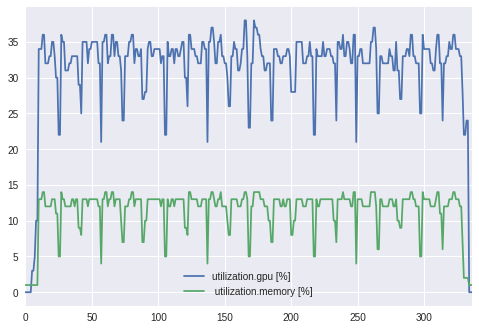

Test loss: 0.13875586477
Test accuracy: 0.9851
Baseline Error: 1.49%
TRAINING took 32.90376651589759 seconds.


In [1]:
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from timeit import default_timer as timer
import platform

from keras_tqdm import TQDMNotebookCallback

print("Python: {}, TensorFlow:{}, Keras:{}".\
      format(platform.python_version(), tf.__version__, keras.__version__))

# Hyperparameters
batch_size = 128
epochs = 20
num_classes = 10

# Load MNIST data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

train_size=len(X_train)
test_size=len(X_test)

X_train = X_train.reshape(train_size, 784)
X_train = X_train.astype('float32')
X_train /= 255
Y_train = keras.utils.to_categorical(Y_train, num_classes)

X_test = X_test.reshape(test_size, 784)
X_test = X_test.astype('float32')
X_test /= 255
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print(X_train.shape, 'TRAIN samples')
print(X_test.shape, 'TEST samples')

model = Sequential()
model.add(Dense(800, activation='relu', input_shape=(784,)))
model.add(Dense(800, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# ----------
import subprocess
import shlex
nvidia_smi_max_timeout = 300
cmd = 'timeout {} nvidia-smi'+\
      ' --query-gpu=utilization.gpu,utilization.memory'+\
      ' --format=csv,nounits -lms 100 -f GPU-info.csv'
cmd = cmd.format(nvidia_smi_max_timeout)
print("Running process: [{}]".format(cmd))
nvidia_smi = subprocess.Popen(shlex.split(cmd))
# ----------

# ===== EVERYTHING ABOVE HERE IS IDENTICAL BETWEEN "Plain fit" and "with Generator".


time_start = timer()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0, callbacks=[TQDMNotebookCallback()],
                    validation_data=(X_test, Y_test))
training_time = timer()-time_start

scores = model.evaluate(X_test, Y_test, verbose=0)

# ----------
import time
time.sleep(0.5)
nvidia_smi.terminate()
time.sleep(0.5)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("darkgrid")
gpu = pd.read_csv("./GPU-info.csv")
gpu.plot()
plt.show()
# ----------

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("TRAINING took {} seconds.".format(training_time))